<a href="https://colab.research.google.com/github/overlord-17/Food-Net/blob/main/FoodNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-a6b6c100-37e9-f0b1-ccbd-cb7eb1229422)


# Importing required libraries

In [ ]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
import datetime

from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import accuracy_score, classification_report

# Use Tensprflow Datasets to download Food101 dataset

In [ ]:
import tensorflow_datasets as tfds
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteV2IYJI/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteV2IYJI/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Features of Food101 dataset
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get class names
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
len(class_names)

101

# Exploring the dataset

In [ ]:
# Output info about a training sample
for image, label in train_data.take(1):
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class (tensor form): {label}
  Class name: {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class (tensor form): 56
  Class name: huevos_rancheros
  


In [ ]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [ ]:
# Min and max values in the image
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

> Looks like the image tensors have values between 0 and 255 and the datatype is `uint8`. So these needs to be preprocessed.

## Visualizing data

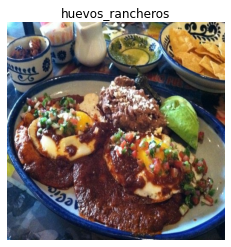

In [ ]:
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False);

# Data Preprocessing

## Creating preprocessing function

In [ ]:
def preprocess_img(image, label, image_shape=300):
  """
  Converts image datatype from 'unit8' to 'float32' and reshapes the image
  to (image_shape, image_shape, colour_channels)
  """
  image = tf.image.resize(image, [image_shape, image_shape])
  return tf.cast(image, tf.float32), label

In [ ]:
# Trying out the function on an single image
preprocessed_img = preprocess_img(image, label)[0]
print(f"""
Image before preprocessing: \n {image[:2]}...
Shape: {image.shape}
Datatype: {image.dtype}
""")
print(f"""
Image after preprocessing: \n {preprocessed_img[:2]}...
Shape: {preprocessed_img.shape}
Datatype: {preprocessed_img.dtype}
""")


Image before preprocessing: 
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...
Shape: (512, 512, 3)
Datatype: <dtype: 'uint8'>


Image after preprocessing: 
 [[[231.81516  253.35333  251.      ]
  [227.05333  254.39214  251.0424  ]
  [218.96422  255.       251.93155 ]
  ...
  [116.63686  108.83265  107.09023 ]
  [ 98.55997   94.715706 100.45451 ]
  [ 71.50786   70.92603   78.93088 ]]

 [[226.97214  254.37093  253.0388  ]
  [222.3472   255.       252.17639 ]
  [213.114    255.       253.954   ]
  ...
  [182.65463  173.30865  163.29532 ]
  [166.55116  161.37477  156.54199 ]
  [136.44185  134.26546  131.39333 ]]]...
Shape: (300, 300, 3)
Datatype: <dtype: 'float32'>



## Batch and prepare dataset

> Using `tf.data` API to load data in the most performant way possible and following Tensorflow best practices 

In [ ]:
# Map preprocessing function to training data
train_data = train_data.map(map_func=preprocess_img,
                            num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(
    batch_size=32
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img,
                          num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches and prefetch it
test_data = test_data.batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

train_data, test_data

(<PrefetchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>)

# Create TensorBoard Callback

In [ ]:
def create_tensorboard_callback(dir_name, exp_name):
  log_dir = dir_name + "/" + exp_name + "/" + datetime.datetime.now().strftime(
      "%Y%m%d-%H%M%S"
  )
  callback = TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return callback

# Build Feature Extraction Model

> Using EfficientNet-V2-B3 model which is pretrained on ImageNet to beat the DeepFood paper.

## Download the model from Tensorflow Hub and fine-tune it

In [ ]:
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2"

In [ ]:
tf.keras.backend.clear_session()
def create_model(url):
  feature_extractor_layer = hub.KerasLayer(
      url,
      trainable=True,
      name="feature_extraction"
  )
  model = Sequential([
        layers.Input(shape=[300,300,3]),
        layers.Rescaling(1./255),
        feature_extractor_layer,
        layers.Dropout(0.2),
        layers.Dense(
            101,
            kernel_regularizer=tf.keras.regularizers.l2(0.0001),
            activation="softmax"
        )
  ])
  return model

## Checking out the layers of the model

In [ ]:
model = create_model(efficientnet_url)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 300, 300, 3)       0         
_________________________________________________________________
feature_extraction (KerasLay (None, 1536)              12930622  
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               155237    
Total params: 13,085,859
Trainable params: 12,976,643
Non-trainable params: 109,216
_________________________________________________________________


## Compile the model

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
    metrics=['accuracy']
)

## Fit the model for 50 epochs

In [ ]:
history = model.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data)//32,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[create_tensorboard_callback(
        "training_logs", "efficient_net_v2"
    )]
)

Saving Tensorboard log files to: training_logs/efficient_net_v2/20210906-153229
Epoch 1/50
74/74 [==============================] - 161s 2s/step - loss: 4.6257 - accuracy: 0.0194 - val_loss: 4.4665 - val_accuracy: 0.0747
Epoch 2/50
74/74 [==============================] - 124s 2s/step - loss: 4.4107 - accuracy: 0.0874 - val_loss: 4.1281 - val_accuracy: 0.2071
Epoch 3/50
74/74 [==============================] - 123s 2s/step - loss: 4.0311 - accuracy: 0.1685 - val_loss: 3.5297 - val_accuracy: 0.3321
Epoch 4/50
74/74 [==============================] - 124s 2s/step - loss: 3.4222 - accuracy: 0.2791 - val_loss: 2.8987 - val_accuracy: 0.4076
Epoch 5/50
74/74 [==============================] - 123s 2s/step - loss: 2.9439 - accuracy: 0.3463 - val_loss: 2.3868 - val_accuracy: 0.4997
Epoch 6/50
74/74 [==============================] - 127s 2s/step - loss: 2.5254 - accuracy: 0.4185 - val_loss: 1.9382 - val_accuracy: 0.5599
Epoch 7/50
74/74 [==============================] - 124s 2s/step - loss: 2

74/74 [==============================] - 41s 555ms/step - loss: 1.1270 - accuracy: 0.7122 - val_loss: 0.6742 - val_accuracy: 0.8271


In [ ]:
# Evaluate the model
model.evaluate(test_data)

790/790 [==============================] - 256s 323ms/step - loss: 0.6893 - accuracy: 0.8189


[0.6892645359039307, 0.8188514709472656]

`The model achieves around 82% accuracy on test data`

## Saving the model

In [ ]:
save_dir = "/content/drive/MyDrive/models/FoodNet-EfficientNet-fine-tuned-model"
os.makedirs(save_dir)
model.save(save_dir)

## Plot loss and accuracy curves

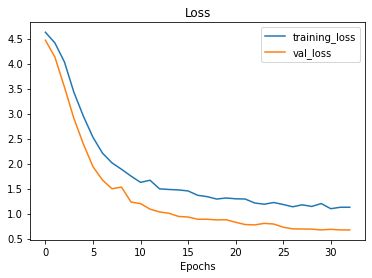

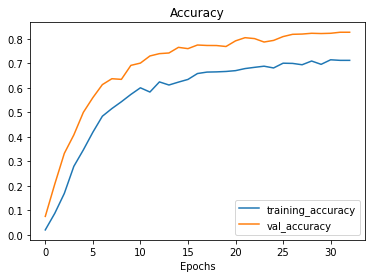

In [ ]:
def plot_curves(history):
  """
  Returns seperate curves for training and validation metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_curves(history)

# View training results on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNet-v2-B3 on Food101 Data" \
  --description "Training results for fine-tuning EfficientNet-v2-B3 on Food101 Data with learning rate 0.005" \
  --one_shot

2021-09-02 14:20:54.366971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-02 14:20:54.459290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-02 14:20:54.459698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy 

# Reloading the model

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/models/FoodNet-EfficientNet-fine-tuned-model")

# Making predictions with the trained model

In [ ]:
pred_probs = model.predict(test_data)
print(f"""
Number of predictions: {len(pred_probs)}
Shape of predictions: {pred_probs.shape}
""")


Number of predictions: 25250
Shape of predictions: (25250, 101)



In [ ]:
# what the prediction probabilities look like
pred_probs[2000]
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[2000])}")
print(f"The class with the highest predicted probability for sample 0: {pred_probs[2000].argmax()}")

Number of prediction probabilities for sample 0: 101
The class with the highest predicted probability for sample 0: 84


# Get the class predictions of each label

In [ ]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

# Test model on custom food images

In [ ]:
def load_and_prep_image(filename, img_shape=300):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (300, 300, 3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  return img

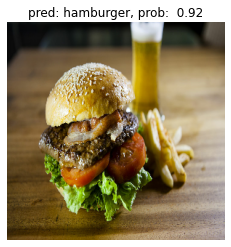

In [ ]:
img = load_and_prep_image("/content/images.jpg")
pred_prob = model.predict(tf.expand_dims(img, axis=0))
pred_class = class_names[pred_prob.argmax()]

plt.figure()
plt.imshow(img/255.)
plt.title(f"pred: {pred_class}, prob: {pred_prob.max(): .2f}")
plt.axis(False);